In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
#scaling the data
def scale_data(data):
    image = data['image']
    return image/255

In [10]:
#load, map, cache, shuffle, batch, prefetch
#reload the data and follow the steps for preprocessing
ds = tfds.load('fashion_mnist', split='train')
ds = ds.map(scale_data) #scaleing the images
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(32)

In [11]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [54]:
def build_generator():
    model = Sequential([
        # Takes in random values and reshapes it to 7x7x128
        Dense(7*7*128, input_dim=128),
        LeakyReLU(0.2),
        Reshape((7, 7, 128)),
        
        # For upsampling block 1
        UpSampling2D(),
        Conv2D(128, 5, padding='same'),
        LeakyReLU(0.2),
        
        # Conv layer 1
        Conv2D(128, 5, padding='same'),
        LeakyReLU(0.2),

        # Conv layer 2
        Conv2D(128, 5, padding='same'),
        LeakyReLU(0.2),

        # For upsampling block 2
        UpSampling2D(),
        Conv2D(128, 4, padding='same'),
        LeakyReLU(0.2),

        # Conv layer 3
        Conv2D(128, 4, padding='same'),
        LeakyReLU(0.2),

        # Conv layer 4
        Conv2D(128, 5, padding='same'),
        LeakyReLU(0.2),
        
        # Final Conv layer
        Conv2D(1, 4, padding='same', activation='sigmoid')
    ])
    
    return model

In [55]:
generator = build_generator()

In [56]:
generator.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 6272)              809088    
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_10 (Reshape)        (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_12 (UpSamplin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                     

In [57]:
import numpy as np

1/1 [==============================] - 0s 200ms/step


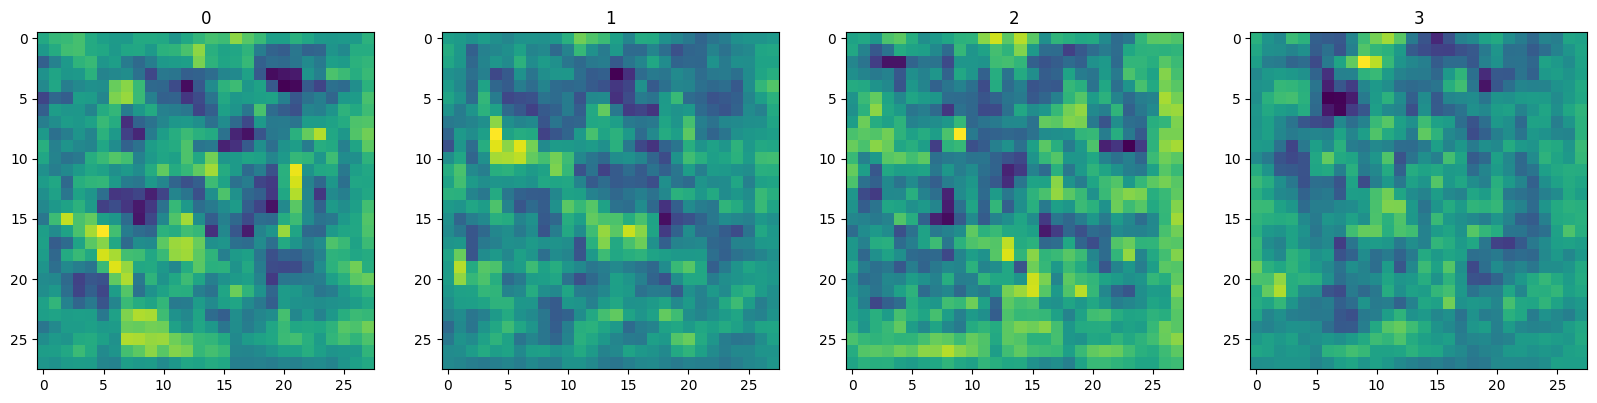

In [58]:
image = generator.predict(np.random.randn(4,128,1))
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    batch = image[idx]
    ax[idx].imshow(np.squeeze(batch))
    ax[idx].title.set_text(idx)